# FatTailedTools: Examples

This notebook is meant to demonstrate the use of the various functions. As **case**, we will use the daily prices of the S&P500 index between 1950 and 2022. This case is in accordance to what is shown in the chapter *"It is what it is": Diagnosing the SP500* in the book *Statistical Consequences of Fat Tails* by Nassim N. Taleb, 2020. The data can, for example, be found on Yahoo Finance.

## 0. Load Data

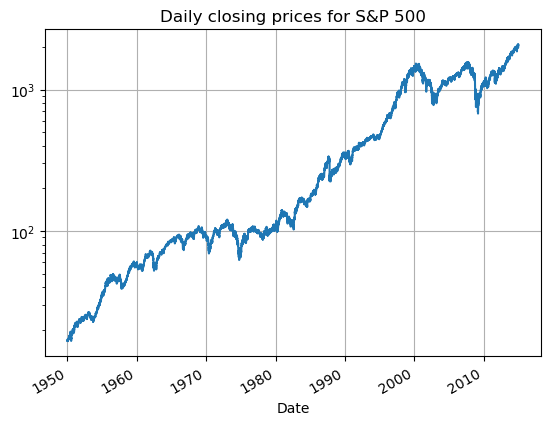

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# Read daily prices of S&P500 from csv file
df = pd.read_csv(
    r'C:\Users\sevsad\OneDrive - SINTEF\Knowlegde Building\Friday Challenges\SP500.csv',
    index_col=[0], usecols=['Date', 'Close']
)

# Make sure the data is sorted
df.sort_index(inplace=True, ascending=True)

# Convert index to DateTimeIndex
df.index = pd.to_datetime(df.index)

# Use data between 1950 and 2022
series = df.loc['1950-01-01':'2014-12-31', 'Close'].dropna()

# Visualize
series.plot(logy=True, grid=True, title='Daily closing prices for S&P 500');

## 1. Calculate Log Returns

In [2]:
from FatTailedTools import returns, tails

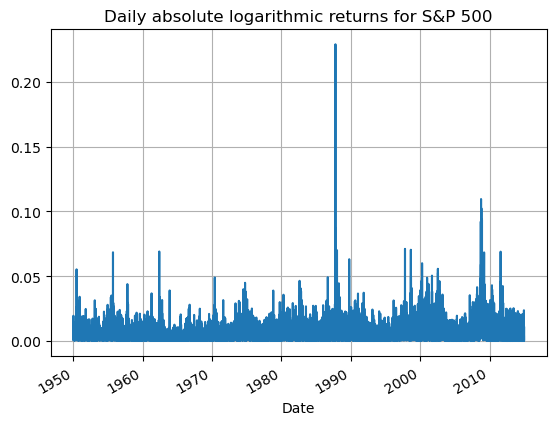

In [3]:
# Get logarithmic returns from daily closing prices of the S&P500 between 1950 and 2022
log_returns = returns.get_log_returns(series=series)

# Get absolute returns
log_returns_abs = tails.get_both_tails(series=log_returns)

# Get returns for left and right tails separately
log_returns_left  = tails.get_left_tail(series=log_returns)
log_returns_right = tails.get_right_tail(series=log_returns)

# Visualize
log_returns_abs.plot(grid=True, title='Daily absolute logarithmic returns for S&P 500');

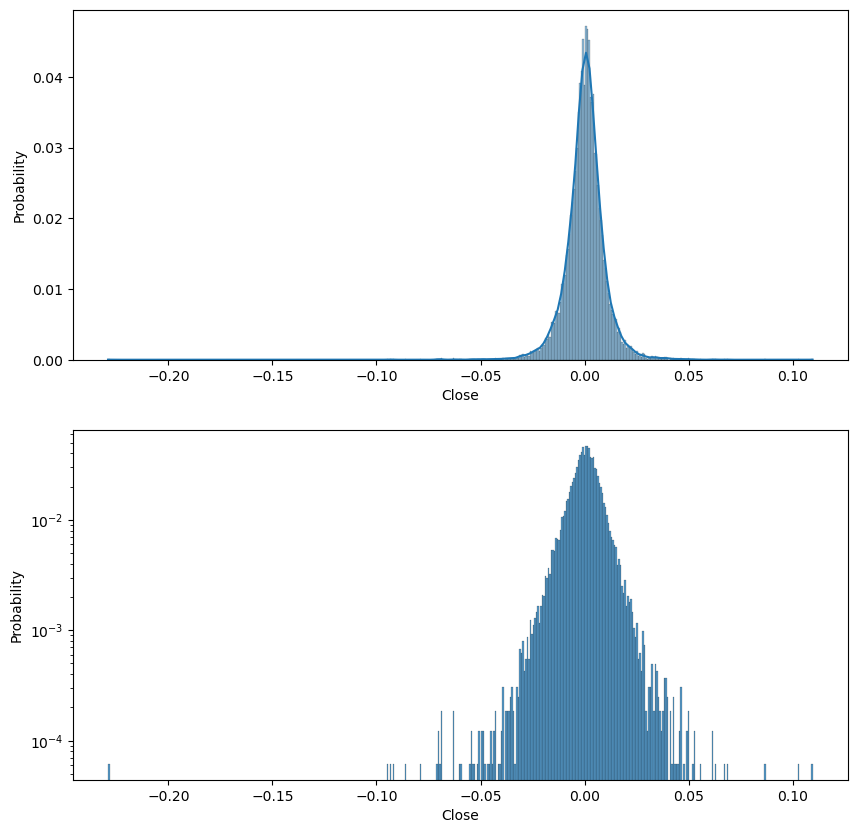

In [4]:
from FatTailedTools import plotting

# Plot a histogram.
plotting.plot_histograms(series=log_returns)

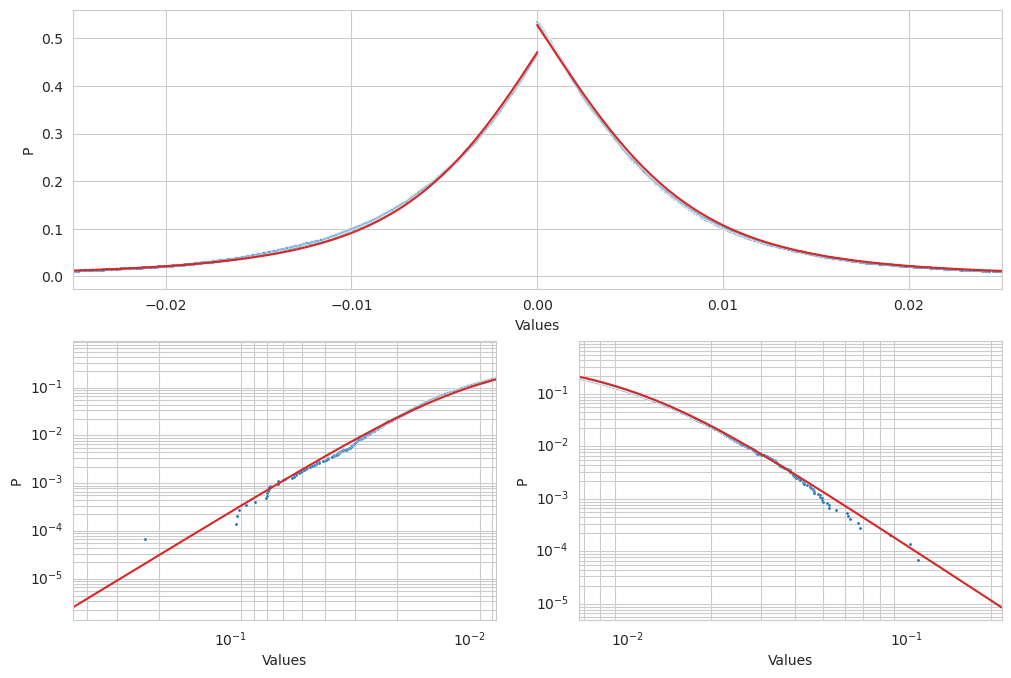

In [8]:
import seaborn as sns
from FatTailedTools import survival
import numpy as np
from scipy.stats import t

# Set up plot
with sns.axes_style('whitegrid'):
    fig, ax = plt.subplot_mosaic([['middle', 'middle'],['left', 'right']], figsize=(10, 10/3*2), constrained_layout=True);

ax['middle'].set_xlim(-0.025, 0.025);

# Right side
survival_func = survival.get_survival_function(log_returns_right)
survival_func['P'] *= (log_returns.dropna() > 0).mean()
sns.scatterplot(data=survival_func, x='Values', y='P', s=5, c='C0', ax=ax['middle']);
sns.scatterplot(data=survival_func, x='Values', y='P', s=5, c='C0', ax=ax['right']);
ax['right'].set_xlim(log_returns_right.std(), log_returns.max()*2);

# Left side
survival_func = survival.get_survival_function(log_returns_left)
survival_func['P'] *= (log_returns.dropna() < 0).mean()
sns.scatterplot(data=survival_func, x='Values', y='P', s=5, c='C0', ax=ax['left']);
ax['left'].set_xlim(2*abs(log_returns.min()), log_returns_left.std());
survival_func['Values'] *= -1
sns.scatterplot(data=survival_func, x='Values', y='P', s=5, c='C0', ax=ax['middle']);

# Fit a Student's t to the right side
dist = t
dist_params = dist.fit(log_returns.dropna(), f0=3.47, loc=0.00047924061847513723, scale=0.006206239363390749)
x_plot = np.linspace(0, log_returns.max()*2, 1000)
ax['middle'].plot(x_plot, dist(*dist_params).sf(x_plot), c='C3');
ax['right'].plot(x_plot, dist(*dist_params).sf(x_plot), c='C3');

# Fit a Student's t to the left side
dist_params = dist.fit(log_returns.dropna(), f0=3.04, loc=0.00047924061847513723, scale=0.006220067387296591)
x_plot = np.linspace(log_returns.min()*2, 0, 1000)
ax['middle'].plot(x_plot, dist(*dist_params).cdf(x_plot), c='C3');
ax['left'].plot(-x_plot, dist(*dist_params).cdf(x_plot), c='C3');

ax['left'].set_xscale('log');
ax['left'].set_yscale('log');
ax['right'].set_xscale('log');
ax['right'].set_yscale('log');
#ax.set_xscale('symlog', linthresh=0.025, linscale=1, subs=range(2,10));
#ax.set_xlabel('X');
#ax.set_ylabel('P(|x| > X)');
ax['left'].grid(which='both')
ax['right'].grid(which='both')

## 2. Visual Identification of Paretianity

In [87]:
from FatTailedTools import alpha

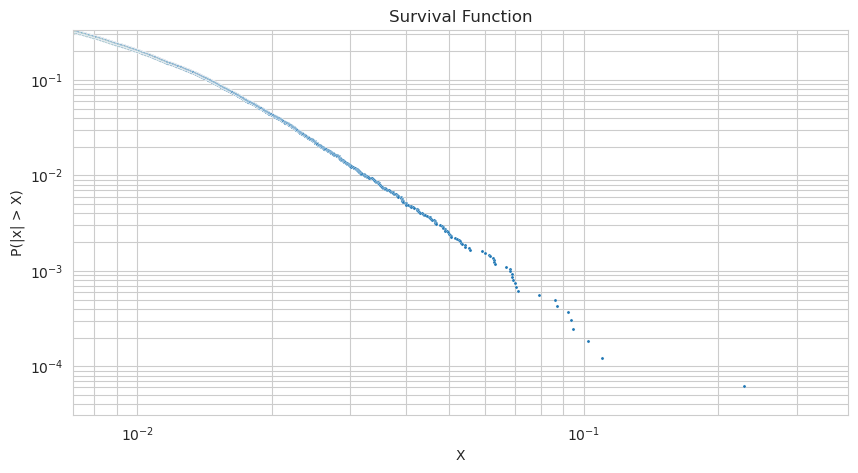

In [88]:
# Plot survival function for absolute returns.
# The huge "outlier" is Black Monday in 1987.
plotting.plot_survival_function(series=log_returns_abs, tail_zoom=True);

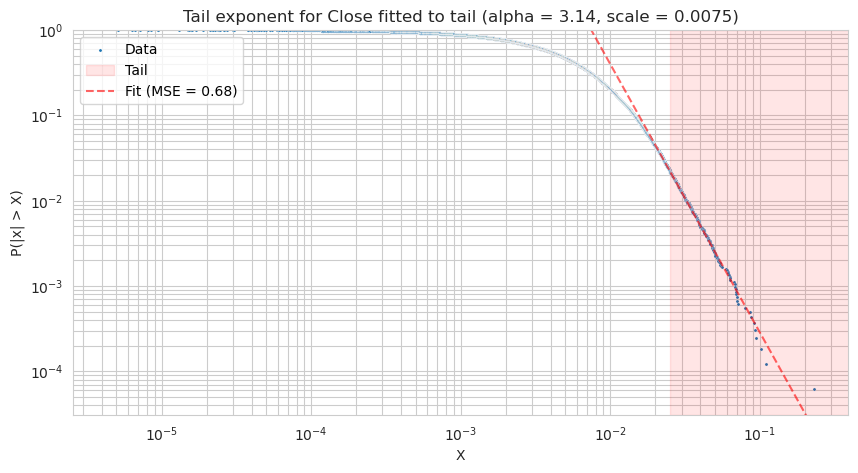

In [91]:
# Based on a first quick look, the tail of the absolute returns seems to be well approximated by a Pareto
# distribution with tail exponent around 3 and scale of around 0.0075:
alpha.fit_alpha_linear(series=log_returns_abs, tail_frac=(log_returns_abs >= 0.025).mean());

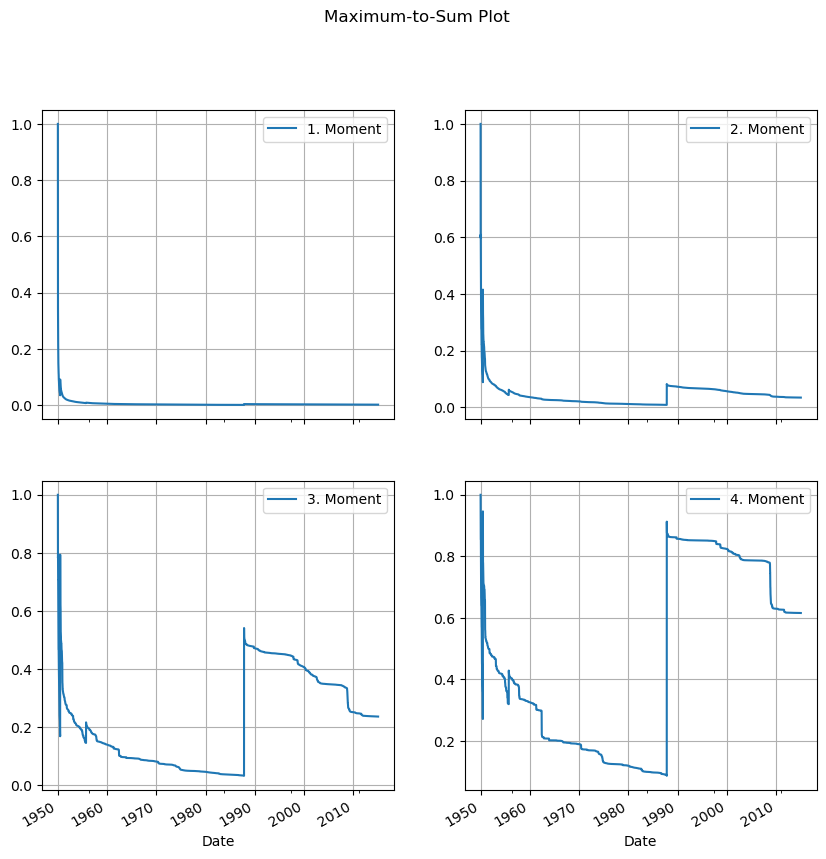

In [8]:
# Plot maximum-to-sum plot for the first 4 moments of the absolute log returns
# The 4. moment clearly does not converge, indicating the non-existence of the fourth moment.
plotting.max_sum_plot(series=log_returns_abs)

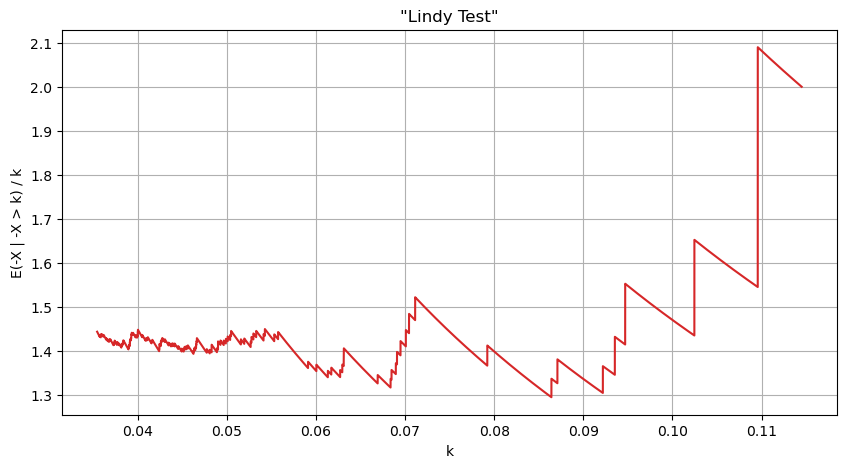

In [9]:
# The Lindy test or conditional expectation below a threshold k.
# As we increase k, the measure should drop. Yet it clearly does not.
plotting.plot_lindy_test(series=log_returns_abs)

(3.197369949961632, 0.00047924061847513723, 0.006166562340891548)

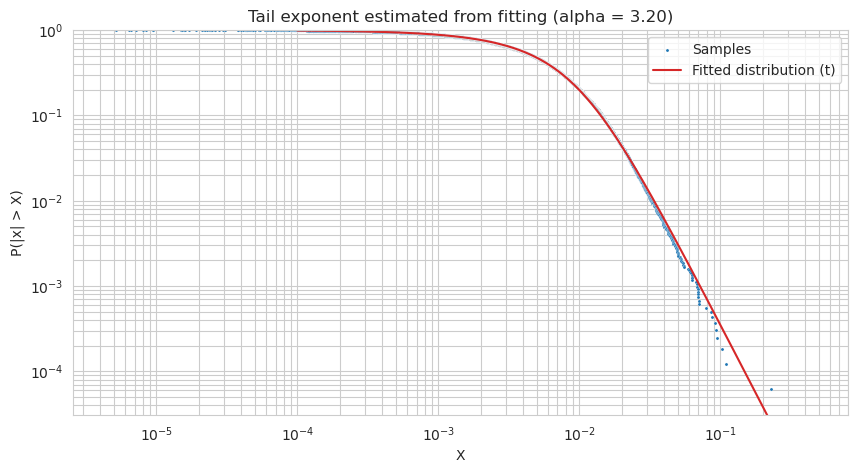

In [125]:
# The data could fit a Student's t with tail exponent (degrees of freedom) of around 3.
alpha.fit_alpha(series=log_returns, return_additional_params=True)

## 3. Max Drawdowns

In [34]:
# Calculate max (logarithmic) drawdowns for 5, 30, 100, and 252 days

max_drawdowns = {}
periods = ['7d', '45d', '150d', '365d']

for period in periods:
    max_drawdowns.update({
        period: returns.get_max_drawdowns(series=series, periods=period, use_log=True)
    })

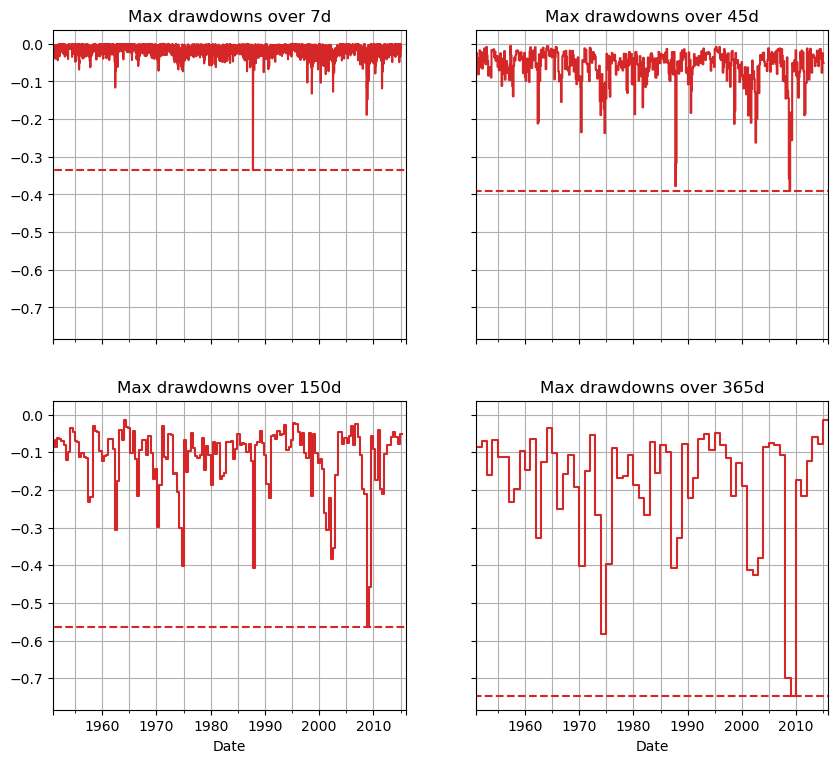

In [35]:
# Visualize
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplot_mosaic(np.array(periods).reshape(2,-1), sharex=True, sharey=True, figsize=(10, 10))

for key, item in max_drawdowns.items():

    max_drawdowns[key].plot(drawstyle='steps', color='C3', ax=ax[key]);
    ax[key].axhline(max_drawdowns[key].min(), *ax[key].get_xlim(), color='C3', linestyle='--');
    ax[key].grid(which='both');
    ax[key].set_title('Max drawdowns over {}'.format(key));

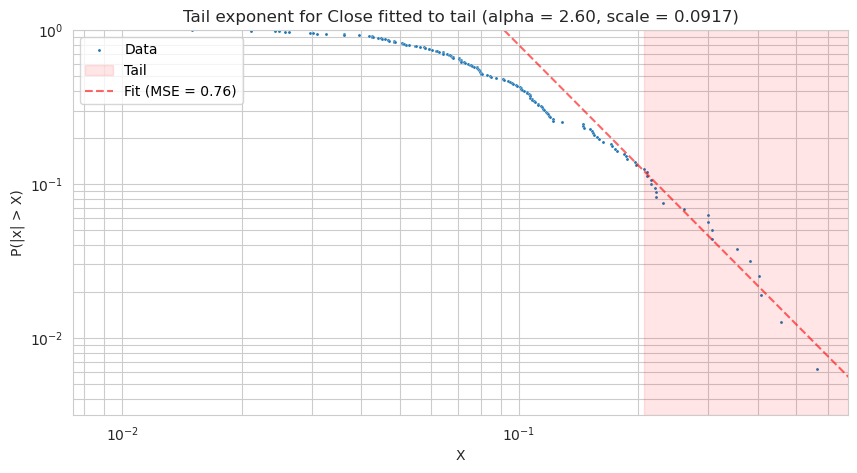

In [34]:
# Plot survival function for max drawdowns for 100d
alpha.fit_alpha_linear(series=max_drawdowns['150d'], tail_frac=(max_drawdowns['150d'] <= -0.2).mean());

## 4. Empirical Kappa

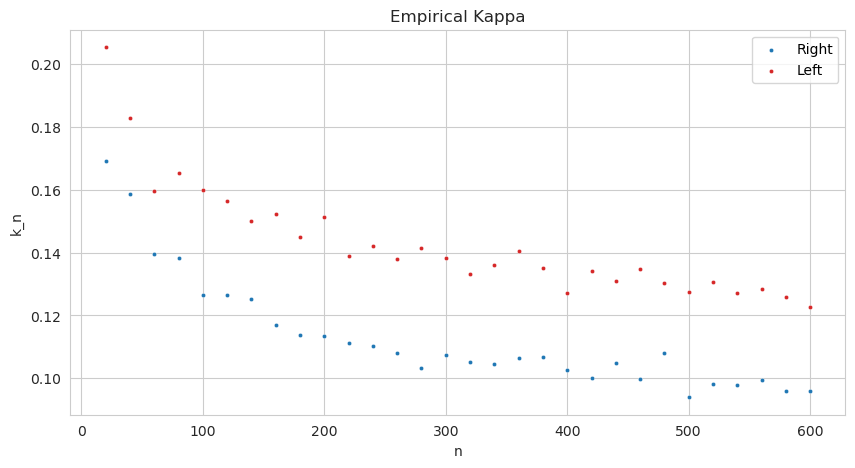

In [189]:
plotting.plot_empirical_kappa_n(series=log_returns, n_bootstrapping=100000)

## 5. Gumbel Test

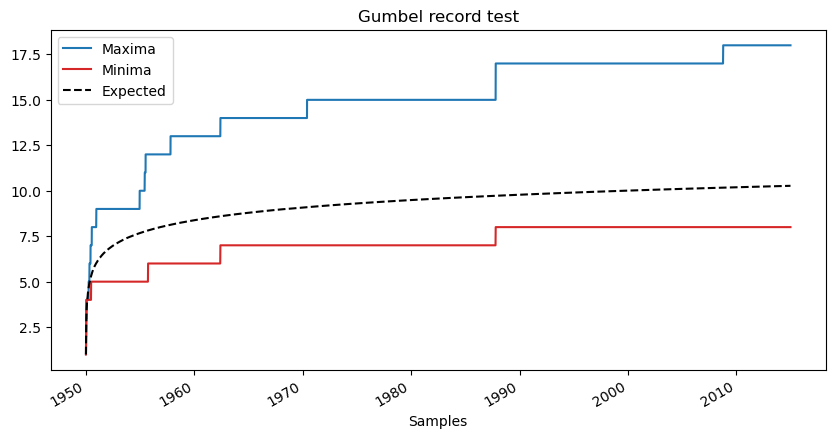

In [194]:
plotting.plot_gumbel_test(series=log_returns)

## 6. Estimating Tail Exponent

### 6.1 Absolute daily (log) returns

C:\Repos\OptionTradingFramework\FatTailedTools\plotting.py:252: UserWarning: Hill estimator temporarily deactivated due to a potential bug in the calculations.
  warnings.warn('Hill estimator temporarily deactivated due to a potential bug in the calculations.')


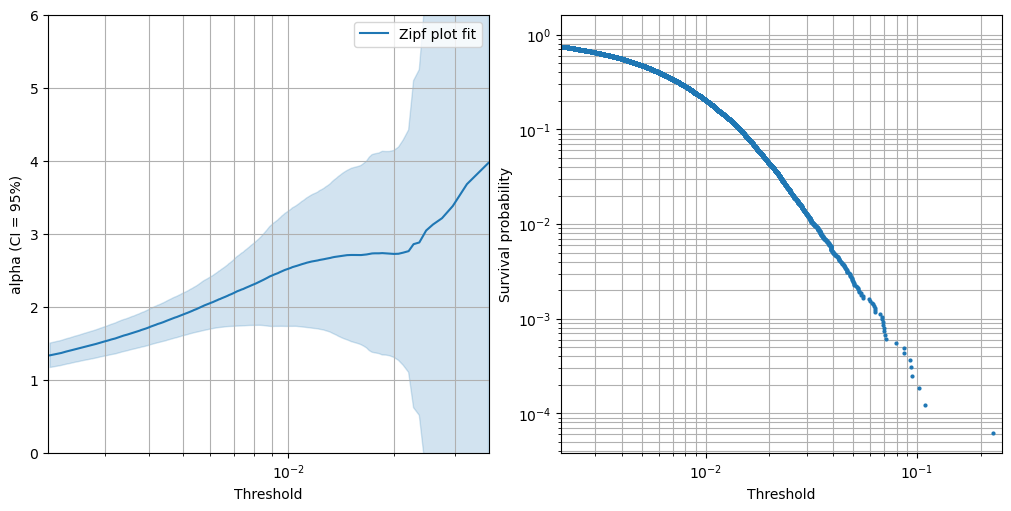

In [7]:
# Visual estimation of tail exponent by varying the assumed tail start
plotting.graphical_alpha_estimation(series=log_returns_abs)

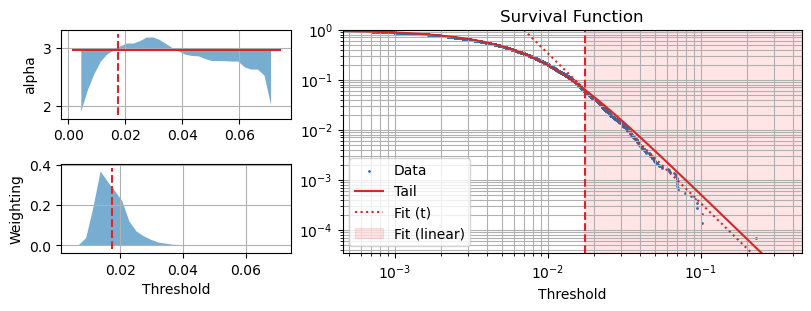

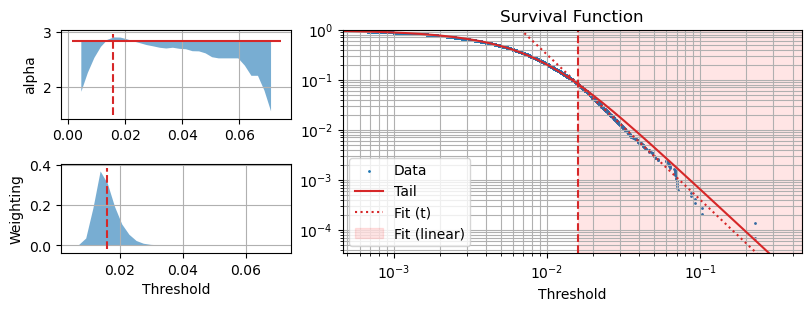

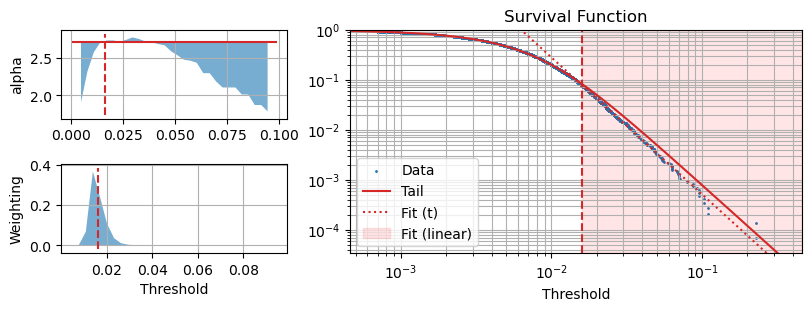

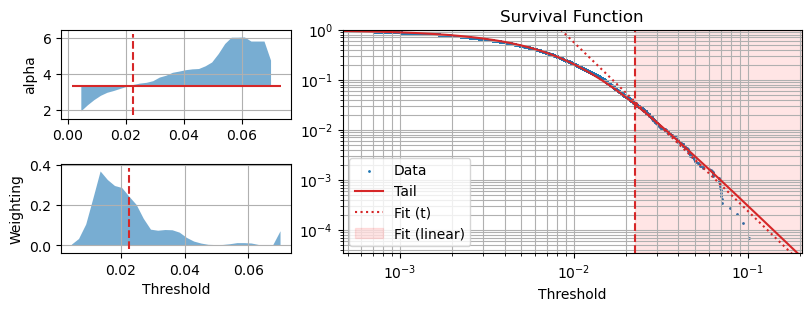

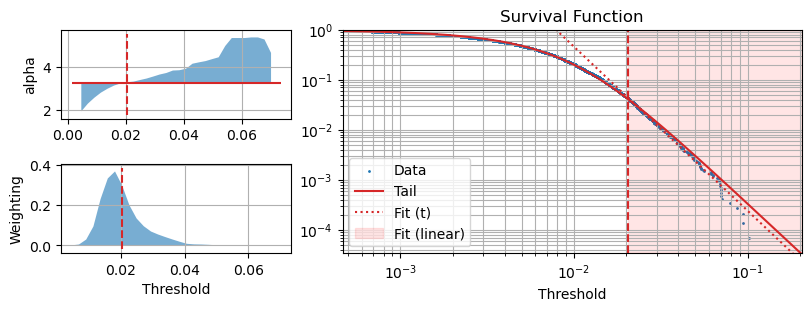

0.006109098521512739 0.3289323987475923


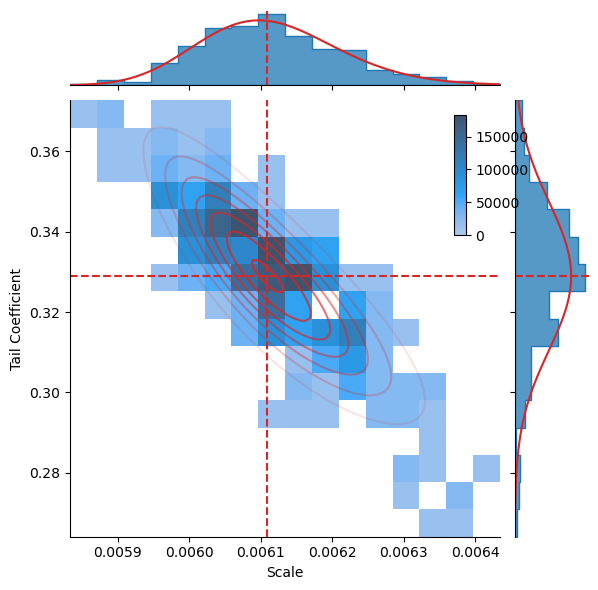

In [16]:
# We can also try to include all sources of uncertainty (via sample bootstrapping and varying the threshold
# beyond which samples are used for the linear MSE fit on the tail in a log-log survival plot.
# The tail exponent is estimated to slightly above 3.
alpha.fit_alpha_and_scale_linear_subsampling(
    data          = series,
    period_days   = 1,
    tail          = 'both',
    n_debug_plots = 5
);

### 6.2 Max drawdowns 150 days

C:\Repos\OptionTradingFramework\FatTailedTools\plotting.py:252: UserWarning: Hill estimator temporarily deactivated due to a potential bug in the calculations.
  warnings.warn('Hill estimator temporarily deactivated due to a potential bug in the calculations.')


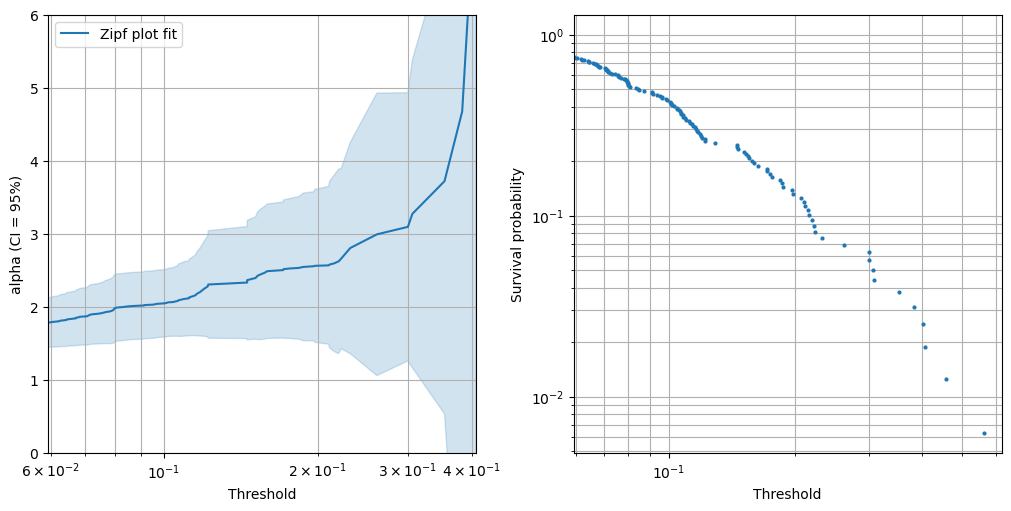

In [14]:
# Visual estimation of tail exponent by varying the assumed tail start
plotting.graphical_alpha_estimation(series=max_drawdowns['150d']);

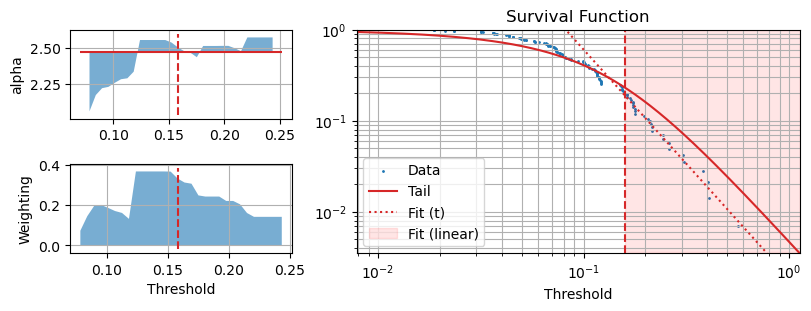

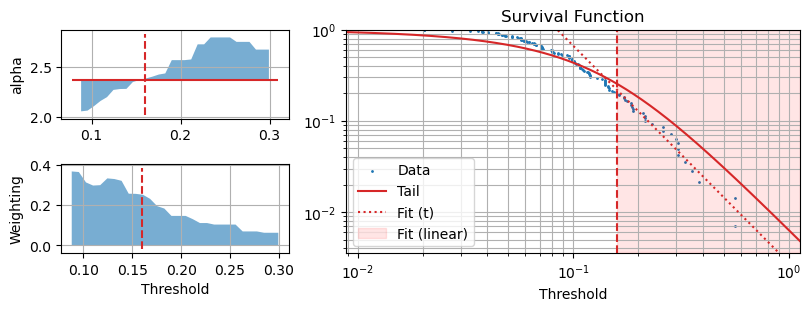

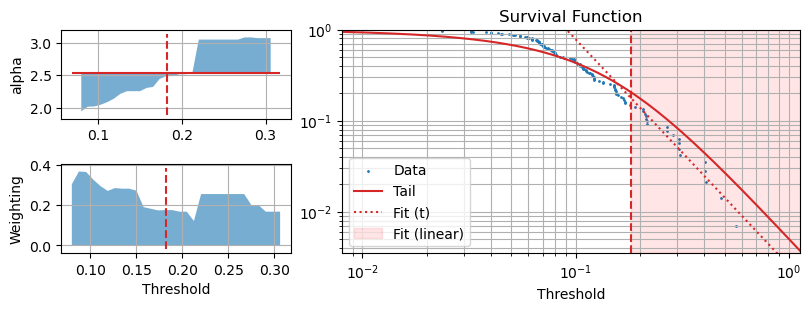

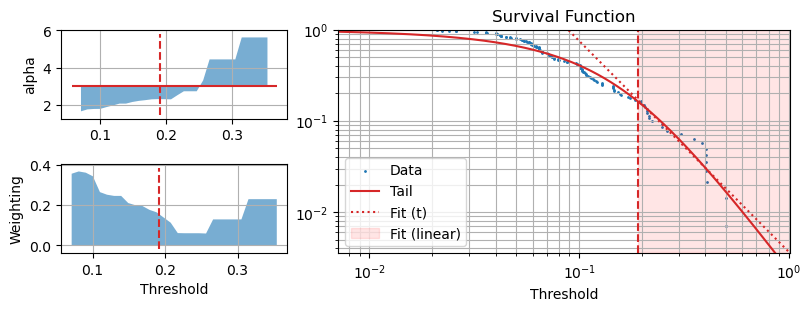

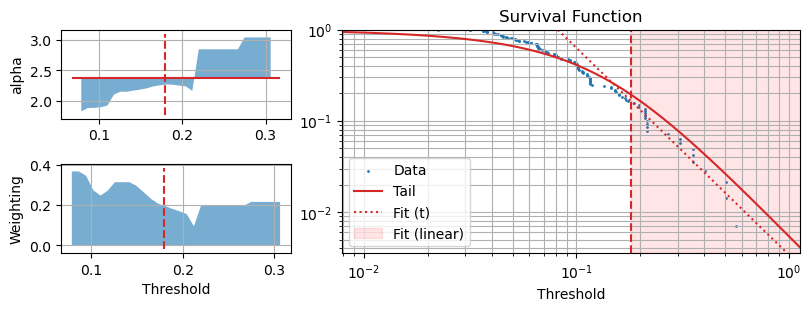

0.1049377379681136 0.3793411846034722


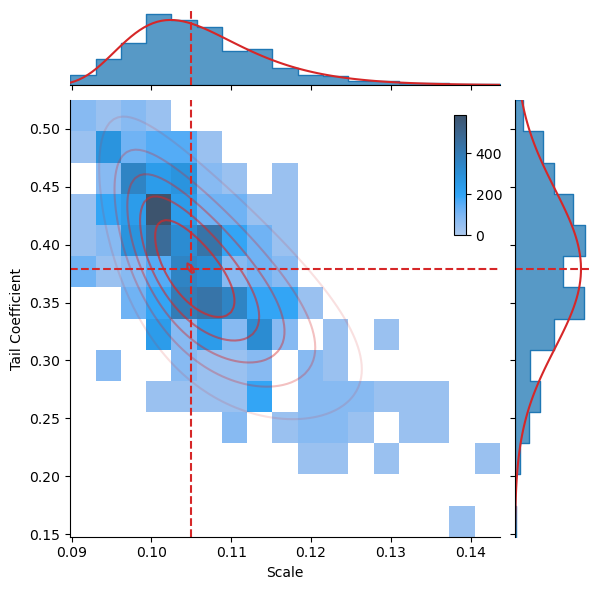

In [13]:
# Proper treatment including all uncertainty we can handle:
# In the data (bootstrapping), which intervals to take when calculating draws over 150 days (time offset),
# and uncertainty wrt. where the tail starts.
# Tail exponent is estimated to around 2.6
alpha.fit_alpha_and_scale_linear_subsampling(
    data                = series,
    period_days         = 150,
    tail                = 'left',
    transformation_func = returns.get_max_drawdowns,
    n_debug_plots       = 5
);